# STAT3009 Recommender System Project 1

## Analysis Notebook

Author: Leung Yuk Hei Boris

Student ID: 1155158560


# Table of Content

1.  [Exploratory Data Analysis](#1-exploratory-data-analysiseda)

2.  [Model Development](#2-model-development)

    2.1 [Baseline Models](#21-baseline-models)

    2.2 [Matrix Factorization](#22-matrix-factorization)

    2.3 [The Hunt for Hyperparameter](#23-the-hunt-for-hyperparameter)
    2.3.1 [Methodology](#231-methodology)
    2.3.2 [BCD-like approach](#232-bcd-like-searching-implementation)
    2.3.3 [Evolutionary Algorithms](#233-evolutionary-algorithms)
    2.3.4 [A Combination of Both](#234-a-combination-of-both-bcd--evolution)

3.  [Result](#3-results)


# 1. Exploratory Data Analysis(EDA)

Before actually implementing any models on this project, it is best for us to get a better know on the dataset, namely `train.csv` and `test.csv`, that we are going to be dealing with. Let's start off with some basic information:

-   Three fields: user_id, item_id, rating
-   Data types: All integer
-   User range: 0 - 599
-   Total number of unique users: 593
-   Item range: 0 - 798
-   Total number of unique items: 785
-   Rating range: 0 - 10
-   Number of rows with missing data: 0

## Data Distributions

We might also be interested in the distribution of the dataset. This helps us better understand which model we might actually want to apply. Nothing gives us more information than some graphs. To begin with, let's take a look at the user and item distribution in the 2 sets, along with the rating's distribution:

<center>

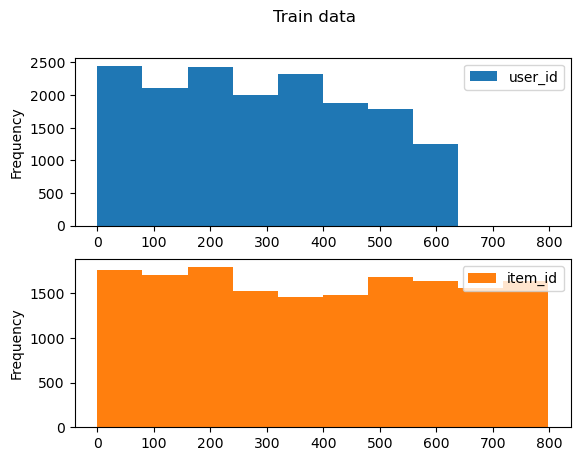
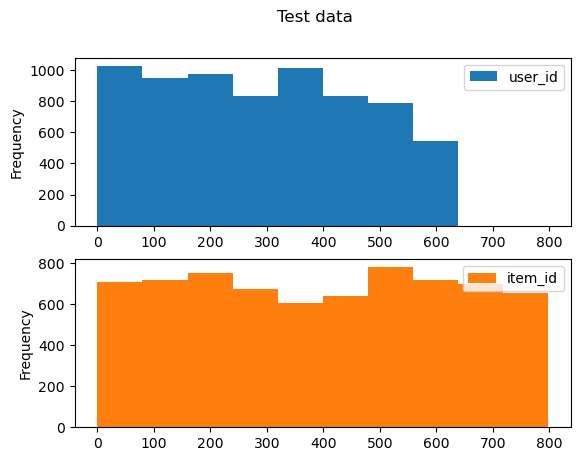
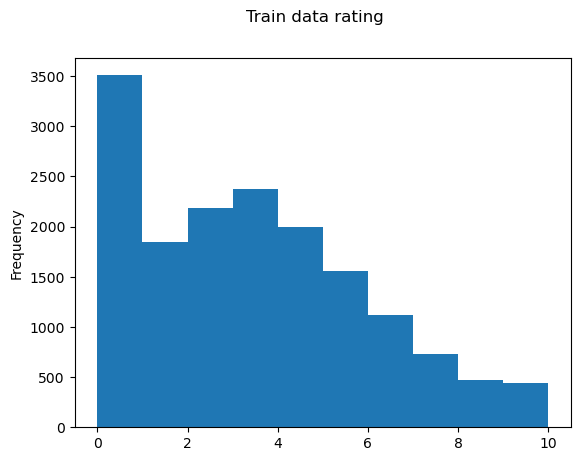

</center>

Both the train set and test set appears to be of a quite similar distribution, which is definitely a good sign to see as it implies that we should be able to create a nice prediction model learning from the train set alone. We can also see that the distributions of both `user_id` and `item_id` are somewhat uniform, with the only exception of `user_id`'s frequency falling off by the end as it approaches 599. Another interesting thing to note is that the `rating` distribution is not uniform or normal at all, instead it is as if it were a triangular distribution centered at around 3 with a much heavy tail around 0.

Let's have a deeper dive into distributions by looking at some violin plots the frequencies of users and items, i.e. the number of times they have rated or being rated:

<center>

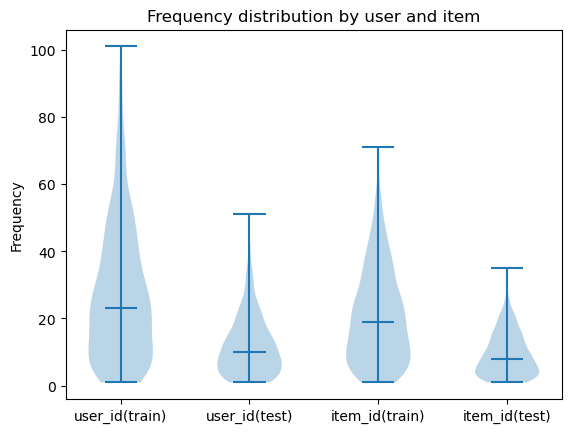

</center>

The plots reveals that there are a lot of user and items with few ratings, forming such an skewed looking distribution. This might also be a hint towards whether popularity of an item or the activeness of a user has anything to do with the prediction.

## Popular Users and Active Users

Here are a few more important parts in the whole data set when dealing with frequencies:

-   Most rated user: user_id 9, with a count of 152
-   Most rated item: item_id 786, with a count of 105
-   Most popular item: 679, with an average rating of 7.729730

Some scatters plots and histogram might reveal more information:

<center>

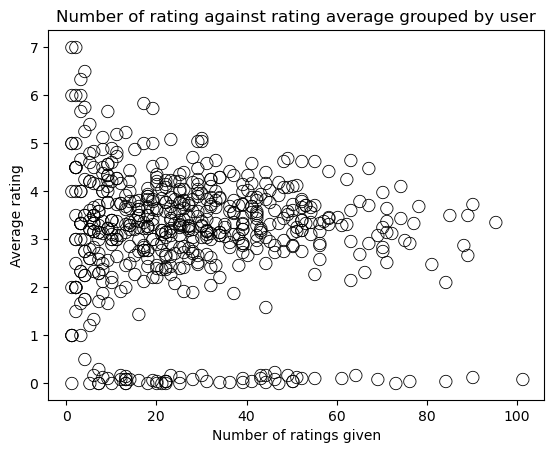
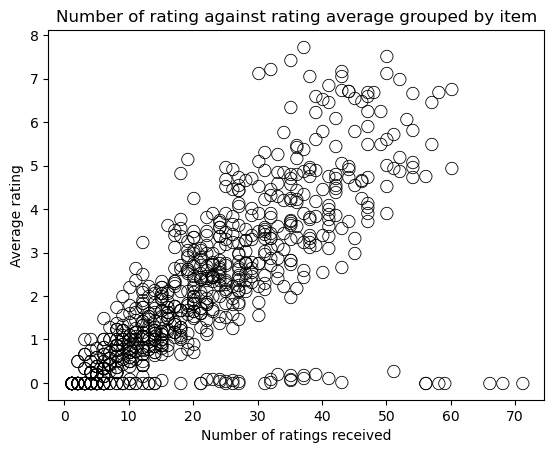

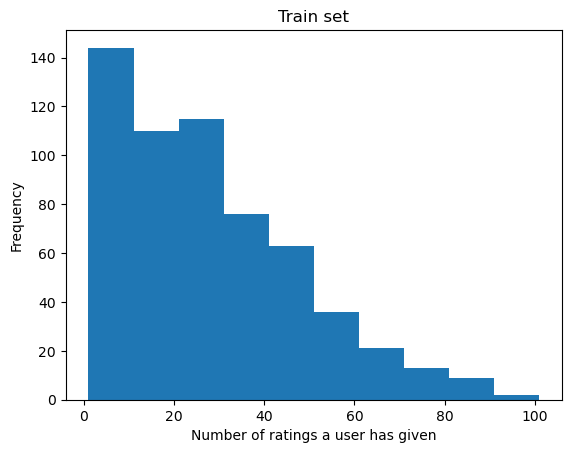
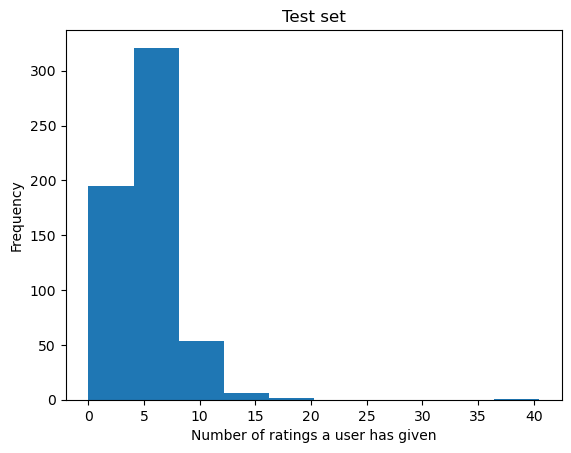

</center>

This is an interesting discovery! Just like the plots in the lecture, the number of ratings seem to have effect on the item's average rating. The frequency of user's number of rating also looks similar, suggesting a potential integration of "user activeness"/"item popularity" in our model. These has to be a hint to prefer some matrix factorization with neighborhood effects, namely SVD and SVD++.

Let's look at some more frequency distributions:

<center>

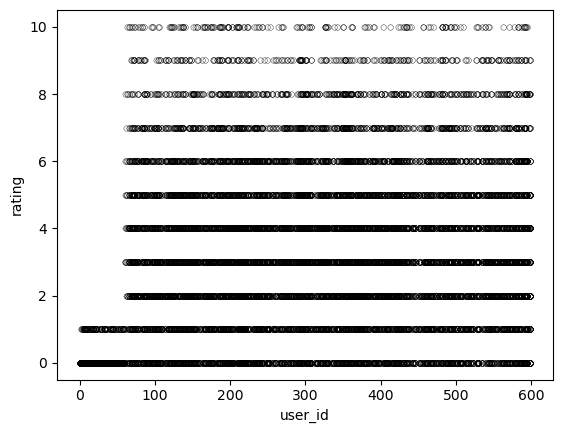
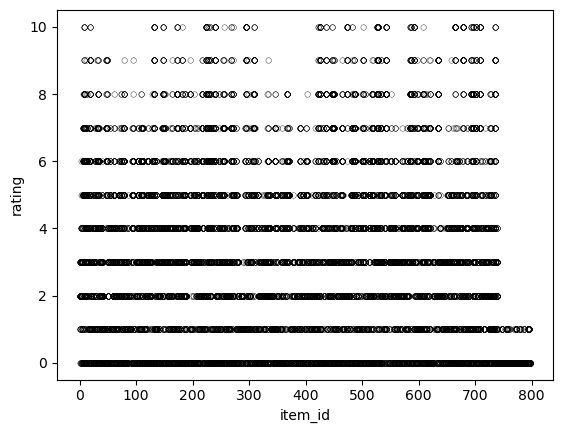

</center>
There are two fascinating discoveries from the two scatter plots above:

-   The lower the rating, the denser the points are (especially significant between 'item_id' and 'rating'), suggesting a bias towards lower ratings overall.
-   There seems to be a "border" between ratings > 1, and either 'user_id' < around 80 or 'item_id' > 750, suggested by a clear empty rectangular areas in both plots. It appears to be manually configured to behave so.


# 2. Model Development

Now comes the main part of the project - creating a model to generate rating predictions. Let's start with the most basic ones:

## 2.1 Baseline Models

To server as a benchmark, we are going to use the following models demonstrated in the lecture. This includes the following models:

-   Global Average Model,
-   User Average Model,
-   Item Average Model,
-   User Average + Item Residual Model,
-   Item Average + User Residual Model,
-   Matrix Factorization Model

These models serve as a baseline for the further models to be evaluated against so as to get a feel of how good our they do. It is believed that we are already very familiar with the above models that no introductions and descriptions for them are required here.

### Results

The training RMSE is as follows, sorted by increasing error:

<center>

| Model                | Train RMSE |
| -------------------- | ---------- |
| MatrixFactorization  | 0.994387   |
| ItemMeanUserResidual | 1.056764   |
| UserMeanItemResidual | 1.147565   |
| ItemMean             | 1.611223   |
| UserMean             | 2.256926   |
| GlobalAverage        | 2.494066   |

</center>

The above shows that there are great potential for matrix factorization algorithms in our current settings. Do note that the RMSE taken here on the matrix factorization model is not tuned, unlike that of the rest requiring no room for adjustments.

### Prediction Analysis and Further Modelling

During my homework attempts, I have come across prediction ratings way out of bounds of the origin rating range. This has led me to develop a "clamping" add-on to the predictions generated, by simply applying a min-max function on the prediction data. The new modified prediction results are as follows:

<center>

| Model                       | Train RMSE |
| --------------------------- | ---------- |
| ClampedItemMeanUserResidual | 0.965831   |
| ClampedMatrixFactorization  | 0.994305   |
| ClampedUserMeanItemResidual | 1.080747   |

</center>

_Note: The pure mean models, i.e. ItemMean, UserMean, and GloablAverage models, are not shown here as they require no clamping. It would not make sense to have an average rating out of range of the original bound. Only the above model could achieve such behaviors._

There are significant improvements to the 3 models, yet the train RMSE is still very high, compared to the current top public score of 0.64100. Perhaps a more complex model would yield better results.


## 2.2 Matrix Factorization

As suggested the section above, matrix factorization methods seem to gain a bit of favour. Our initial EDA also gave insight to a popularity/activeness-related feature, thus leading us to focus on the following two models:

1. SVD
2. SVD++

### 2.2.1 SVD

SVD is a matrix factorization algorithm with the objective to predict rating $\^r_{ui}$:

<center>

$\^r\_{ui} = \mu + b_u + b_i + q_i^\intercal p_u $

</center>

where $\mu$ is the global mean, $b_u$ is the user bias, $b_i$ is the item bias, and $q_i$ and $p_u$ are the $k$-dimensional latent factors for item and user respectively. The following regularized squared error is minimized:

<center>

$\sum_{r_{ui} \in R_{train}} \left(r_{ui} - \hat{r}_{ui} \right)^2 + \lambda\left(b_i^2 + b_u^2 + ||q_i||^2 + ||p_u||^2\right)$

</center>

Note that except $\mu$, all other variables are updated sequentially with stochastic gradient descent:

<center>

$b_u \leftarrow b_u + \gamma (e_{ui} - \lambda b_u)\\
b_i \leftarrow b_i + \gamma (e_{ui} - \lambda b_i)\\
p_u \leftarrow p_u + \gamma (e_{ui} \cdot q_i - \lambda p_u)\\
q_i \leftarrow q_i + \gamma (e_{ui} \cdot p_u - \lambda q_i)$

</center>

where $e_{ui} = r_{ui} - \hat{r}_{ui}$. This model essentially is a combination of global mean, user mean, item mean, and matrix factorization models. It is also possible to use an unbiased version where there are no the equation becomes:

<center>

$\^r\_{ui} = q_i^\intercal p_u $

</center>
making it identical to pure matrix factorization but with stochastic gradient descent.

#### Initial Performance

SVD performed very well on the data set. At the very beginning, a naive brute force approach on a sparse set of parameters was used to find the optimal ones. The number of epochs on stochastic gradient descent is chosen to be fixed at 200, since this number is found to be big enough for the values to converge and the relative time tradeoff is acceptable.

<center>

| Parameters | Representing Variable | List of values                  |
| ---------- | --------------------- | ------------------------------- |
| n_factors  | $k$                   | `np.arange(5, 500, 25)`         |
| lr_all     | $\gamma$              | `10 ** (np.arange(-5, 0, 0.4))` |
| reg_all    | $\lambda$             | `10 ** (np.arange(-5, 0, 0.4))` |

</center>

Fitting the best parameter with a 3-fold cross validation in this preliminary round of search into SVD achieved a decent score. The final parameter and scores are:

<center>

|          | Model | `n_factors` | `lr_all` | `reg_all` | Train RMSE | Public Score RMSE |
| -------- | ----- | ----------- | -------- | --------- | ---------- | ----------------- |
| Attempt1 | SVD   | 80          | 0.03981  | 0.1       | 0.71646    | 0.66628           |

</center>


### 2.2.2 SVD++

The SVD++ algorithm essentially is an upgraded version of SVD, by taking implicit ratings into account. The prediction $\^r_{ui}$ becomes:

<center>

$\hat{r}_{ui} = \mu + b_u + b_i + q_i^T\left(p_u +
|I_u|^{-\frac{1}{2}} \sum_{j \in I_u}y_j\right)$

</center>

where $y_j$ is a set of item factors designed to model their respective implicit ratings. SVD++ updates itself with stochastic gradient descent also.

#### Initial Performance

Again, we are also making an initial attempt here. A similar setting as [above](#performance) is used here:

<center>

| Parameters | Representing Variable | List of values                  |
| ---------- | --------------------- | ------------------------------- |
| n_factors  | $k$                   | `np.arange(3, 250, 2)`          |
| n_epochs   | N/A                   | `np.arange(100, 1901, 200)`     |
| lr_all     | $\gamma$              | `10 ** (np.arange(-5, 0, 0.4))` |
| reg_all    | $\lambda$             | `10 ** (np.arange(-5, 0, 0.4))` |

</center>

Fitting the best parameter with a 3-fold cross validation in this first round of search into SVD++ achieved similar scores:

<center>

|          | Model | `n_factors` | `n_epochs` | `lr_all` | `reg_all` | Train RMSE | Public Score RMSE |
| -------- | ----- | ----------- | ---------- | -------- | --------- | ---------- | ----------------- |
| Attempt2 | SVD++ | 137         | 1500       | 0.00630  | 0.1       | 0.72342    | 0.66389           |

</center>

which is not an improvement when compared to our first attempt with SVD. However, I would argue that the two public scores of these 2 attempts are very close to each other, which its performance cannot be truly tested with such an initial sparse scan on hyperparameters.

### Remarks: Cross Validation and Its Weird Behavior

Cross validation is a very common technique in machine learning to combat the issue of overfitting. In this project, using cross validation is a defacto setting. However, choosing the right fold for cross validation also seems to have effect on the model development. Throughout the entire coarse of this project, the number of fold in cross validation seems to have a significant impact on the model development, which is actually very new to me.

In my [first attempt](#22-svd), a 3-Fold cross validation is used to pick the right hyperparameter. Surprisingly, by manipulating the number of folds, we can get a very different set of hyperparameter values as well as training error during our initial search.

<center>

| Fold | `n_factor` | `lr_all` | `reg_all` | Train RMSE | Public score RMSE |
| ---- | ---------- | -------- | --------- | ---------- | ----------------- |
| 2    | 450        | 0.003162 | 0.0031622 | 0.74594    | 0.65766           |
| 3    | 80         | 0.039810 | 0.1       | 0.71646    | 0.66628           |
| 4    | 55         | 0.039810 | 0.1       | 0.70164    | 0.65893           |
| 5    | 137        | 0.006309 | 0.1       | 0.72342    | 0.70530           |

</center>

As we can see from the table above, the difference is actually very significant, especially on the RMSEs. Folds of 2, 3 and 4 seems to work well while any number larger than 5 appears to malfunction. This is a rather strange behavior as usually 3 and 5 folds are the go-to folds in a cross validation, yet 5 folds here actually have a very undesirable behavior. The discovery of this phenomenon has to thanks to my obstinacy. I have spent multiple attempts on models trained with 5-fold cross validation, thinking that would yield a more optimal solution due to the increased training data, yet ultimately to no avail. The list of public score RMSEs on the prediction from models trained with an initial parameter grid similar to [this](#initial-performance) is as follows:

<center>

| Model             | Attempt-CV5-1 | Attempt-CV5-2 | Attempt-CV5-3 | Attempt-CV5-4 | Attempt-CV5-5 |
| ----------------- | ------------- | ------------- | ------------- | ------------- | ------------- |
| Public score RMSE | 0.7053        | 0.71524       | 0.70502       | 0.70251       | 0.7053        |

</center>

There were progress made within these several tuning attempts, yet unfortunately it appears that CV5 somehow found a local minima for the parameters during the initial search, ultimately producing a worse performance than [attempt1](#22-svd). The only explanation for this is perhaps that 5-fold is too much for the algorithms, to either converge to an optimal set of hyperparameter or not to overfit on the training set.


## 2.3 The Hunt for Hyperparameter

Now that we have the SVD and SVD++ model at hand, it's time to further fine tune the hyperparameter in order to achieve a better result.

### 2.3.1 Methodology

When it comes to locating the parameters, we need a methodological approach in order to maximize our chances. The following few steps have been devised to guide the entire choosing process:

1. A sparse and wide range of values is picked for each hyperparameter.
2. Test all the combinations between the different hyperparameter with cross validation.
3. Find the set of hyperparameter achieving the lowest error for further investigation.
4. Produce a new narrower range of values for each hyperparameter centered on the best ones found in step 4.
5. Repeat step 2 until we find the best hyperparameter, the error stops reducing, or the error repeatedly only drops by an insignificant amount.

In order to facilitate the search, [GridSearchCV](https://surprise.readthedocs.io/en/stable/model_selection.html#surprise.model_selection.search.GridSearchCV) from the Python package [Surprise](https://surpriselib.com/) is used. It has a similar implementation of [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) from another well-known Python package, [scikit-learn](https://scikit-learn.org/stable/index.html). This class provides support for the brute-force search mentioned above along with cross validation and multiprocessing, which makes it an ideal candidate for our setting.

In addition to using a handpicked list of candidate values to search, sometimes it might be better to use a distribution instead. This provides several benefits, namely more flexible range to work with and performance increase, since the combination of all the parameters grows in terms of exponential, making it a very hard time for GridSearchCV when there a lot of hyperparameter to tune. [RandomizedSearchCV](https://surprise.readthedocs.io/en/stable/model_selection.html#surprise.model_selection.search.RandomizedSearchCV) might come in handy as it supports distributions as inputs and has a fixed number of sampling sets of hyperparameter values. It is found that by supplying a normal distribution with mean as the best hyperparameter value and the third of that value as standard deviation works well.

### 2.3.2 BCD-like Searching Implementation

However, in practice the combination of values of hyperparameter could be "explode" due to its nature of exponential structure, as mentioned in the above section. Although the best way is indeed to go through all the combinations, this has become rather impractical as there are a maximum of 17 hyperparameter to tune in both SVD and SVD++. Let's say we have a list of 10 candidate values for each hyperparameter, that would make a total of $10^{17}$ trials, an outrageously enormous number. Using a random search with limited sampling iteration on such an humongous combination would also seem daunting as it is more like finding a needle in a haystack.

Inspired by the blockwise coordinate descent(BCD) algorithm learned during lecture, along with the mindset of above, a more practical and efficient implementation has been created:

1. Use a rather sparse yet computable grid of hyperparameter to do a preliminary search. Save the best hyperparameter.
2. Fix a portion of hyperparameter in their so far best value
3. Allow a considerable amount of them to carry out a [step 4](#231-methodology)-like list.
4. Perform a grid search on this new set.
5. Fix another portion of the hyperparameter and repeat step 3 until all the hyperparameter has been tuned once in the current iteration.
6. Select the top 5 most performant value of the hyperparameter and perform a grid search, if possible. Otherwise, skip this step.
7. Use the best hyperparameter again and repeat step 2 until convergence.

I deliberately added an extra step, i.e. step 6, to attempt at mitigate any randomness in producing a lucky result and also hope to achieve a synergy effect among the top few values. Below is the algorithm in action on SVD++:

<center>

| Attempt                     | `n_factors` | `n_epochs` | `lr_all` | `reg_all` | `reg_bu`(fixed) | `reg_bi`(fixed) | Train RMSE | Public score RMSE |
| --------------------------- | ----------- | ---------- | -------- | --------- | --------------- | --------------- | ---------- | ----------------- |
| 2 (from [SVD++](#222-svd))  | 137         | 1500       | 0.00630  | 0.1       | 0               | 0               | 0.72342    | 0.66389           |
| BCD-1 (find `n_factors`)    | 1           | 1500       | 0.00630  | 0.1       | 0               | 0               | 0.68624    | 0.66533           |
| BCD-2 (find `n_epochs`)     | 1           | 641        | 0.00630  | 0.1       | 0               | 0               | 0.69134    | 0.66031           |
| BCD-3 (find `lr_all`)       | 1           | 641        | 0.009    | 0.1       | 0               | 0               | 0.68528    | 0.66096           |
| BCD-4 (find `reg_all`)      | 1           | 641        | 0.009    | 0.06      | 0               | 0               | 0.68952    | 0.65893           |
| BCD-5 (Generalizing layer)  | 1           | 461        | 0.009    | 0.057     | 0               | 0               | 0.681066   | 0.65774           |
| BCD-6 (find `n_factors`)    | 1           | 461        | 0.009    | 0.057     | 0               | 0               | 0.681066   | 0.65774           |
| BCD-7 (find `n_epochs`)     | 1           | 584        | 0.009    | 0.057     | 0               | 0               | 0.68857    | N/A               |
| BCD-8 (find `lr_all`)       | 1           | 584        | 0.009    | 0.057     | 0               | 0               | 0.69004    | N/A               |
| BCD-9 (find `reg_all`)      | 1           | 584        | 0.009    | 0.0655    | 0               | 0               | 0.0655     | N/A               |
| BCD-10 (Generalizing layer) | 1           | 584        | 0.005    | 0.064     | 0               | 0               | 0.69004    | 0.65887           |

</center>

As can be seen from the table above, the RMSE does appear to reduce from the initial 0.66389 to the lowest point of 0.65774, which at its time is a milestone achievement of protruding the 0.66 line. A similar effect can be seen in SVD:

<center>

| Attempt                  | `n_factors` | `n_epochs` | `lr_all` | `reg_all` | `reg_bu`(fixed) | `reg_bi`(fixed) | Train RMSE | Public score RMSE |
| ------------------------ | ----------- | ---------- | -------- | --------- | --------------- | --------------- | ---------- | ----------------- |
| 1 (from [SVD](#221-svd)) | 80          | 200        | 0.03981  | 0.1       | 0               | 0               | 0.71646    | 0.66628           |
| BCD-1 (find `n_factors`) | 1           | 200        | 0.03981  | 0.1       | 0               | 0               | 0.69243    | N/A               |
| BCD-2 (find `n_epochs`)  | 1           | 72         | 0.03981  | 0.1       | 0               | 0               | 069076     | N/A               |
| BCD-3 (find `n_epochs`)  | 1           | 72         | 0.03981  | 0.1       | 0               | 0               | 0.696418   | N/A               |
| BCD-4 (find `lr_all`)    | 1           | 72         | 0.033    | 0.1       | 0               | 0               | 0.68472    | N/A               |
| BCD-5 (find `lr_all`)    | 1           | 72         | 0.033    | 0.047     | 0               | 0               | 0.69316    | 0.65774           |

</center>

It can also be seen that the RMSE indeed did decrease after running the algorithm.

### 2.3.3 Evolutionary Algorithms

Manually picking the new value range after each iteration could be cumbersome and may lead to mistakes. That's why I have also developed a script to automatically do a similar thing when compared to above. Inspired by nature, evolutionary algorithms have find its way solving many problems. The idea behind these evolutionary algorithms are rather straightforward:

1. Eliminate the weak candidates
2. Produce more variants with similar traits from the survived candidates
3. Loop until convergence

As for the definition of "weak" and "strong" candidates, it depends. In the current implementation, I have used a survival rate of 0.1 and 0.2, which means in every iteration, only 10% or 20% of the models trained in RandomSearchCV get to remained, and from those models I will try to fit ether a normal, or other distributions on their individual hyperparameter. The cycle continues until convergence. Below are some graphs generated during a series of learning with SVD++, with 3-fold cross-validation, 8 evolutions, 0.2 survival rate:

<center>
<figure class="image">

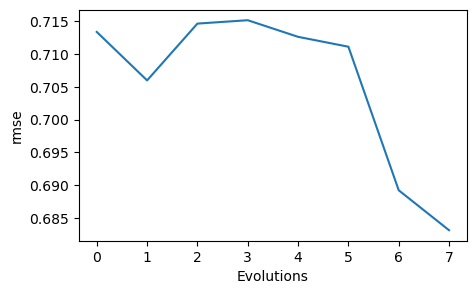

<figcaption>RMSE against evolution</figcaption>
</figure>
</center>
<center>
<figure class="image">

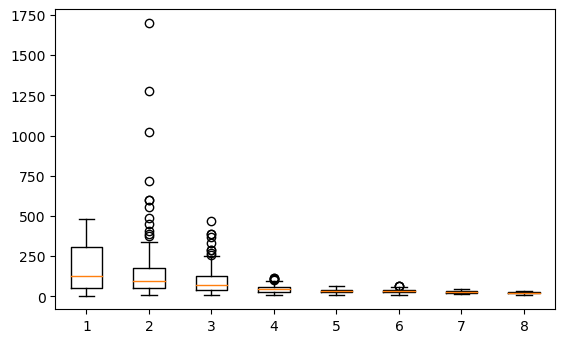

 <figcaption>n_factors converging over iterations</figcaption>
</figure>
</center>
<center>
<figure class="image">

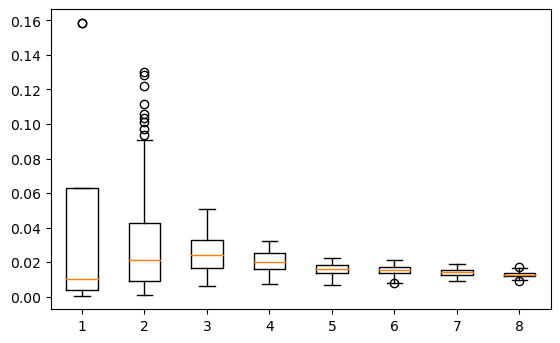

<figcaption>lr_all converging over iterations</figcaption>
</figure>
</center>
<center>
<figure class="image">

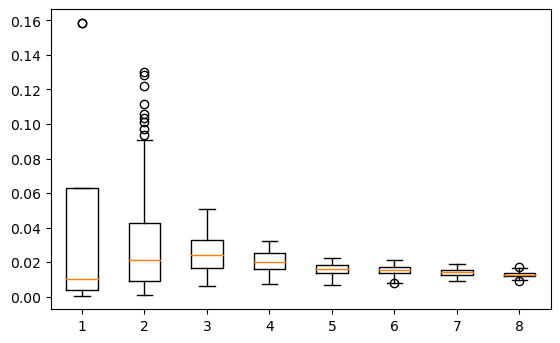

<figcaption>reg_all converging over iterations</figcaption>
</figure>
</center>

The top model of each iteration are as follows:

<center>

| Attempt                  | `n_factors` | `n_epochs` (fixed at 200) | `lr_all` | `reg_all` | `reg_bu`(fixed) | `reg_bi`(fixed) | Train RMSE | Public score RMSE |
| ------------------------ | ----------- | ------------------------- | -------- | --------- | --------------- | --------------- | ---------- | ----------------- |
| 1 (from [SVD](#221-svd)) | 80          | 200                       | 0.03981  | 0.1       | 0               | 0               | 0.71646    | 0.66628           |
| Evolution(1)             | 23          | 200                       | 0.00905  | 0.13060   | 0               | 0               | 0.68311    | 0.66898           |
| Evolution(2)             | 11          | 200                       | 0.00347  | 0.13108   | 0               | 0               | 0.70597    | N/A               |
| Evolution(3)             | 26          | 200                       | 0.01238  | 0.12598   | 0               | 0               | 0.71464    | 0.66494           |
| Evolution(4)             | 14          | 200                       | 0.00876  | 0.18567   | 0               | 0               | 0.71515    | 0.67176           |
| Evolution(5)             | 15          | 200                       | 0.00700  | 0.12496   | 0               | 0               | 0.71262    | 0.67312           |
| Evolution(6)             | 1           | 200                       | 0.00568  | 0.057925  | 0               | 0               | 0.70214    | 0.66713           |
| Evolution(7)             | 1           | 200                       | 0.00769  | 0.05963   | 0               | 0               | 0.69714    | 0.66714           |
| Evolution(8)             | 1           | 200                       | 0.00986  | 0.05753   | 0               | 0               | 0.68304    | 0.66584           |

</center>

Although judging by the public scores above, there does not seem to have a much improvement, in fact the algorithm even performed worse most of the time, but ultimately the algorithm did manage to find its way back. A more successful result is obtained by running the entire algorithm on 4-fold cross-validation evolving only on learning rates and regularization parameter, i.e. `lr_all` and `reg_all`. Again, the number of folds in cross validation has some weird interference here, as had described [above](#remarks-cross-validation-and-its-weird-behavior).

<center>
<figure class="image">

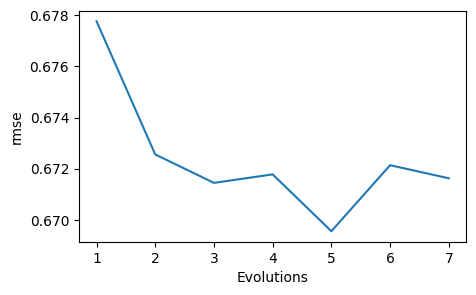

<figcaption>A more successful evolution on 4-fold CV</figcaption>
</figure>
</center>

A possible problem could be that the sampling distributions are not implemented correctly, thus converging to a bad state per iteration. The other reason could be that the survival rate is not optimal, which would lead to a bad sampling distribution. In an attempt to mitigate the latter problem, regarding the survival rate, I attempted to create an "elite" version of the algorithm, with a survival rate of only 0.01, which in a 1000 iteration sample would make it only the top 10 could make it to the next iteration. This has proven to be a disaster.

<center>
<figure class="image">

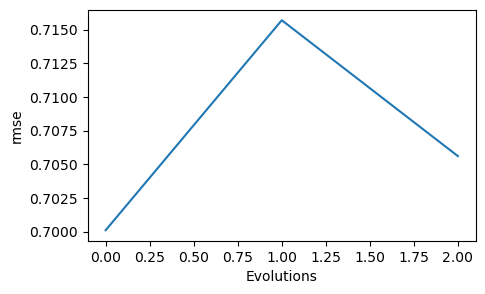

<figcaption>High train error with "elite" evolution</figcaption>
</figure>
</center>


### 2.3.4 A Combination of Both: BCD + Evolution

At my final attempt to master SVD and SVD++ models, a combination of the two methods above was combined and things begin to look promising. I tried to focus on a subset of the parameters in each evolution(1 evolution can contain multiple iterations of learning). Then, I will pick the best evolution and use those parameters for my next BCD iteration, focusing on the other parameters. So on and so forth until convergence is reached. Below are some plots on the training errors during the first iteration of the entire process.

<center>
<figure class="image">

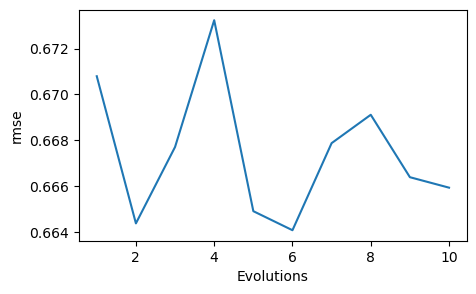

<figcaption>RMSE against evolution during evolution 1 training on lr_bu, lr_bi, reg_bu, reg_bi</figcaption>
</figure>

</center>

<center>
<figure class="image">

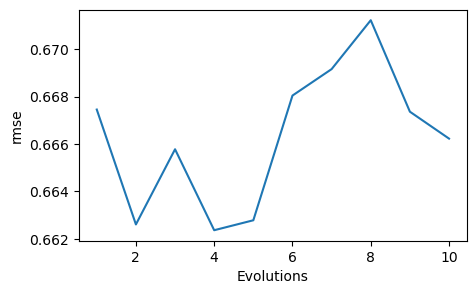

<figcaption>RMSE against evolution during evolution 1 training on lr_pu, lr_qi, reg_pu, reg_qi</figcaption>
</figure>

</center>

<center>
<figure class="image">

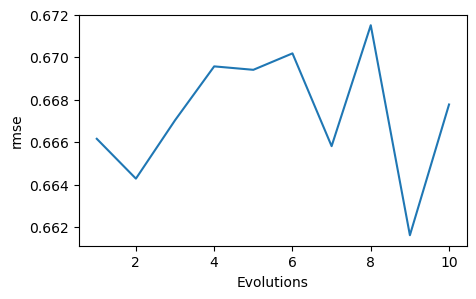

<figcaption>RMSE against evolution during evolution 1 training on lr_yj, reg_yj</figcaption>
</figure>

</center>

In this attempt, I have separated the variables into 3 groups and allow them evolve independently, namely the learning rate and regularization `bu` and `bi`, `pu` and `qi`, and `yj`. This has proven to be very successful. The best result is achieved by the second iteration during training on `pu` and `qi` in their 2nd evolution:

<center>

| Model      | Train RMSE | Public score RMSE |
| ---------- | ---------- | ----------------- |
| evo(2)-pq2 | 0.6586     | 0.6467            |

</center>


# 3. Results

My SID is 1155158560, The 560th record will be printed:


In [2]:
import pandas as pd
from surprise import Dataset, Reader
from surprise.prediction_algorithms.matrix_factorization import SVDpp

import os

DATA_DIR = "data"
train_data = pd.read_csv(os.path.join(DATA_DIR, "train.csv"))
X = pd.read_csv(os.path.join(DATA_DIR, "test.csv"))

reader = Reader(rating_scale=(0, 10))
data = Dataset.load_from_df(train_data, reader)
full_train_data = data.build_full_trainset()
from cv_logs import load_model

model = load_model("SVDpp_evo(2)_(pq2)")
SID = 560
prediction = pd.read_csv("predictions/SVDpp_evo(2)_(pq2).csv", usecols=["Id", "rating"])
test = pd.read_csv("data/test.csv")

print("record")
print(test[test.index == SID - 1])
print("pred_rating: ", prediction["rating"][SID - 1])
import numpy as np

pred_item_rating = np.zeros(798)

for i in range(798):
    pred_item_rating[i] = model.predict(469, i + 1).est

print("Top 5 preferred items:")
print(np.argsort(pred_item_rating)[-5:] + 1)

record
     user_id  item_id
559      469       76
pred_rating:  5.124596521528925
Top 5 preferred items:
[425 295 679 473 664]
